In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import notebookcfa27bdb31 as ArrayGenerator
from tsai.all import *
from fastai.callback.all import *
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.integration import FastAIPruningCallback
import random

In [4]:
df = pd.read_pickle(
    "/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle"
)

In [5]:
X = np.array(df["ts"].to_list())
y = np.array(df["standardized_faults"])

In [6]:
# changed split method to split by bearing
raw_X, raw_y = ArrayGenerator.generate_dataset_array(
    dataset_category=3, ts=X, labels=y, split_method="bearing"
)

{'Faults classified': 'Flow problem', 'Channels taken': 'Machine channels only', 'Labels array': 'Binary'}


In [20]:
#  applying SaveModelCallback to get the best results and earlystopping to prevent overfitting
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor="f1_score", comp=np.greater, patience=3),
    SaveModelCallback(monitor="f1_score", comp=np.greater, fname="best_model"),
]

In [12]:
tfms = [None, [TSStandardize(by_var=False), Categorize()]]
batch_tfms = [TSStandardize(by_var=False)]

In [13]:
report_splits = get_splits(raw_y, valid_size=0.2, shuffle=True, show_plot=False)
X_train1, y_train1 = raw_X[report_splits[0]], raw_y[report_splits[0]]
X_test1, y_test1 = raw_X[report_splits[1]], raw_y[report_splits[1]]

In [15]:
X_train, y_train = ArrayGenerator.apply_sliding_window(
    X_train1, y_train1, window_size=2048, with_fft=1, overlap_pct=0.764187497961177
)
X_test, y_test = ArrayGenerator.apply_sliding_window(
    X_test1, y_test1, window_size=2048, with_fft=1, overlap_pct=0
)
train_balance_splits = get_splits(
    y_train,
    valid_size=0,
    balance=True,
    strategy="oversample",
    shuffle=True,
    show_plot=False,
)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
dls = get_ts_dls(
    X,
    y,
    splits=splits,
    tfms=tfms,
    shuffle_train=True,
    batch_tfms=batch_tfms,
    bs=[80, 256],
)

valid == train


In [21]:
model = xresnet1d50_deeper(dls.vars, dls.c)
learn = Learner(
    dls,
    model,
    lr=0.07264289989558839,
    metrics=[accuracy, Precision(), Recall(), F1Score(), BalancedAccuracy()],
)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.150668,0.744409,0.876214,0.876777,0.880952,0.878860,0.876120,00:18
1,0.167380,1.071853,0.813107,0.923567,0.690476,0.790191,0.815535,00:17
2,0.225781,0.994473,0.876214,0.856502,0.909524,0.882217,0.875554,00:17
3,0.222764,1.640476,0.844660,0.929412,0.752381,0.831579,0.846488,00:17
4,0.195819,0.857122,0.813107,0.844560,0.776190,0.808933,0.813838,00:17
5,0.173782,0.836986,0.827670,0.906433,0.738095,0.813648,0.829444,00:17


Better model found at epoch 0 with f1_score value: 0.8788598574821853.


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
4,0.195819,0.857122,0.813107,0.84456,0.77619,0.808933,0.813838


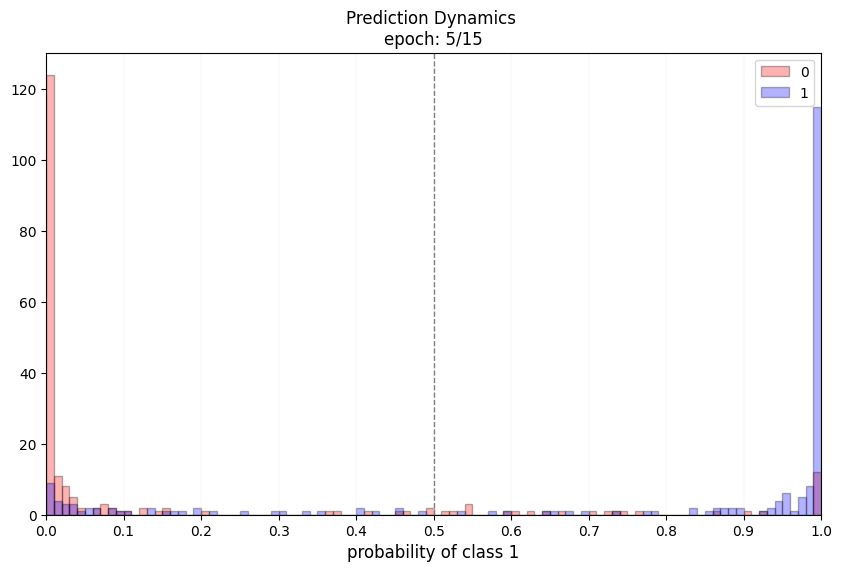

Better model found at epoch 2 with f1_score value: 0.8822170900692841.
No improvement since epoch 2: early stopping


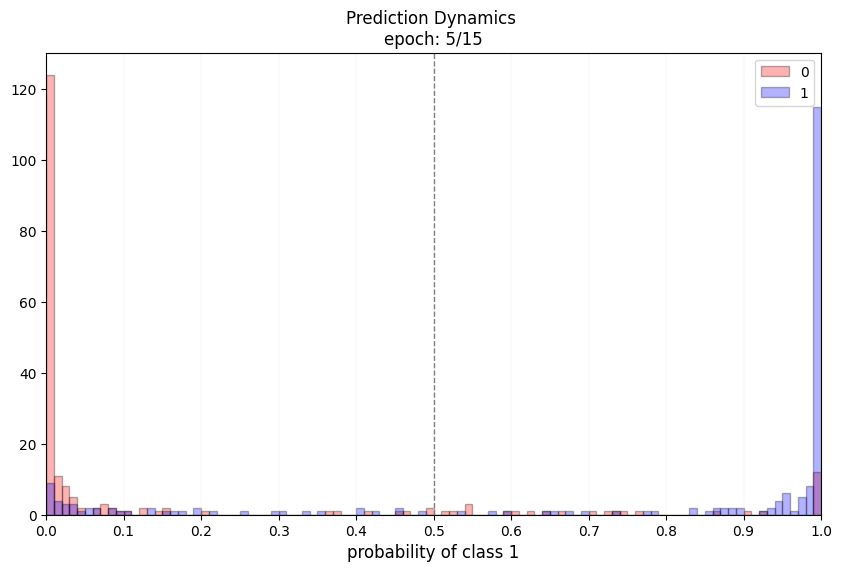

In [22]:
learn.fit_one_cycle(15, cbs=callbacks)

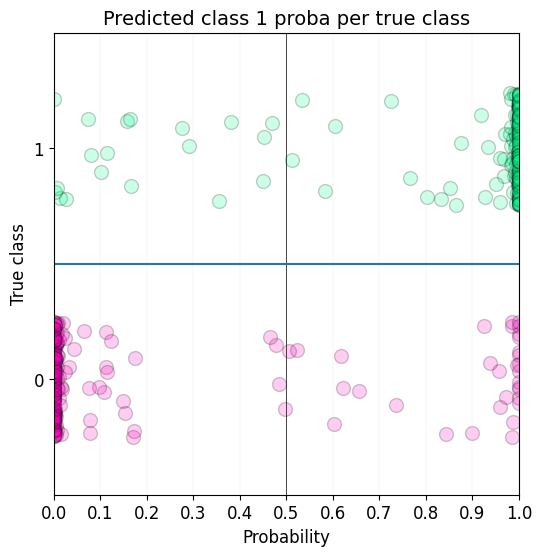

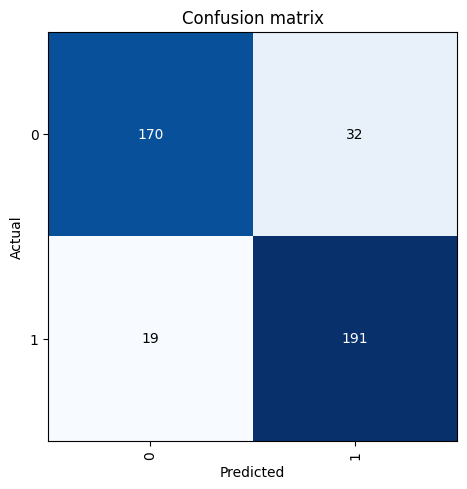

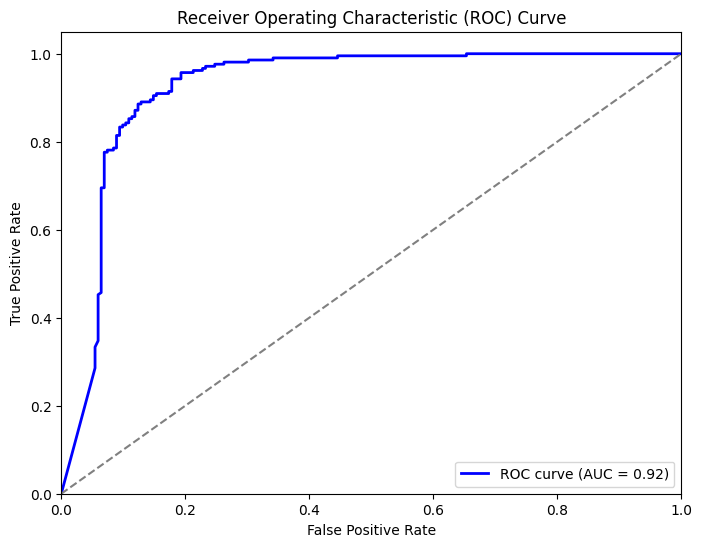

In [23]:
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

positive_probs = valid_probas[:, 1]
# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [24]:
learn.validate()[-2]  # Savemodelcallback loaded the model with the highest

0.8822170900692841